In [19]:
import pandas as pd
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn
import pyspark
from pathlib import Path
import csv
import datetime
import statistics
import xgboost as xgb
from shiny import reactive
from shiny.express import input, ui
from shinywidgets import render_widget
import ipyleaflet as ipyl

In [4]:
# Preprocessing

In [3]:
patient_folder = Path(r"E:/Downloads/25939312/46724347_Glucdict Dataset/Glucdict Dataset/")

Load all the sensor data for each user first since that is more complicated.
We won't use the phone activity files since not every patient has it

In [61]:
sensor_map = {
    1:  "ACCELEROMETER",
    2:  "MAGNETIC_FIELD",
    4:  "GYROSCOPE",
    9:  "GRAVITY",
    10: "LINEAR_ACCELERATION",
    11: "ROTATION_VECTOR",
    18: "STEP_DETECTOR",
    19: "STEP_COUNTER",
    21: "HEART_RATE",
    99: "EARTH_ACC"
}


def load_user_sensor_data(user_id, patient_folder):
    """
    Robustly loads and concatenates all sensor data CSV files containing 'SensorReader' 
    from a user's folder (including Phone/Sensors and Watch), adds a user_id column.
    Filters out malformed lines and handles large files line by line.
    """
    user_path = os.path.join(patient_folder, user_id)
    sensor_dfs = []

    for root, _, files in os.walk(user_path):
        for file in files:
            if "SensorReader" in file and file.endswith(".csv"):
                file_path = os.path.join(root, file)
                try:
                    chunks = []
                    for chunk in pd.read_csv(
                        file_path,
                        usecols=[0, 1, 2, 3, 4],
                        header=None,
                        chunksize=10000,
                        engine='python',
                        on_bad_lines='skip'
                    ):
                        chunk.columns = ['sensor', 'timestamp', 'x', 'y', 'z']
                        chunk['user_id'] = user_id
                        chunk['timestamp'] = pd.to_datetime(pd.to_numeric(chunk['timestamp'], errors='coerce'), unit='ms', errors='coerce')
                        for col in ['x', 'y', 'z']:
                            chunk[col] = pd.to_numeric(chunk[col], errors='coerce')
                        chunks.append(chunk)
                    if chunks:
                        sensor_dfs.append(pd.concat(chunks, ignore_index=True))
                except Exception as e:
                    print(f"[ERROR] Failed to process {file_path}: {e}")

    if not sensor_dfs:
        return pd.DataFrame()

    return pd.concat(sensor_dfs, ignore_index=True)

In [ ]:
# for example:
test1 = load_user_sensor_data('User1', patient_folder)
test1.head()

In [40]:
def extract_sensor_features(df, accel_movement_threshold=1.2):
    """
    Extracts per-user features from 3-axis sensor data, heart rate, and step detector.
    Includes:
    - Mean/std/min/max/median magnitude for each 3-axis sensor
    - Percent time moving from accelerometer
    - Average daily steps from STEP_DETECTOR
    - Resting HR, mean HR, and time in personalized HR zones from HEART_RATE

    Parameters:
        df: DataFrame with columns ['sensor', 'timestamp', 'x', 'y', 'z', 'user_id']
        accel_movement_threshold: float, magnitude threshold to count as 'moving'
    Returns:
        DataFrame with one row per user, features per sensor
    """
    feature_list = []

    # Ensure x, y, z are numeric
    for col in ['x', 'y', 'z']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    for sensor in df['sensor'].unique():
        if sensor in ['HEART_RATE', 'STEP_DETECTOR']:
            continue

        sensor_df = df[df['sensor'] == sensor].copy()
        sensor_df['magnitude'] = np.sqrt(sensor_df['x']**2 + sensor_df['y']**2 + sensor_df['z']**2)

        grouped = sensor_df.groupby('user_id')['magnitude']
        features = grouped.agg(['mean', 'std', 'min', 'max', 'median'])
        features.columns = [f"{str(sensor).lower()}_{col}" for col in features.columns]

        if str(sensor).lower() == 'accelerometer':
            move_counts = sensor_df.groupby('user_id').apply(
                lambda g: (g['magnitude'] > accel_movement_threshold).sum()
            )
            total_counts = sensor_df.groupby('user_id').size()
            percent_moving = (move_counts / total_counts).fillna(0)
            features[f"{sensor.lower()}_percent_time_moving"] = percent_moving

        feature_list.append(features)

    feature_df = pd.concat(feature_list, axis=1).reset_index()

    if 'STEP_DETECTOR' in df['sensor'].unique():
        step_df = df[df['sensor'] == 'STEP_DETECTOR'].copy()
        step_df['timestamp'] = pd.to_datetime(step_df['timestamp'])
        step_df['date'] = step_df['timestamp'].dt.date

        daily_steps = step_df.groupby(['user_id', 'date']).size().reset_index(name='steps')
        avg_daily_steps = daily_steps.groupby('user_id')['steps'].mean().rename('avg_daily_steps')
        feature_df = feature_df.merge(avg_daily_steps.reset_index(), on='user_id', how='left')

    if 'HEART_RATE' in df['sensor'].unique():
        hr_df = df[df['sensor'] == 'HEART_RATE'].copy()
        hr_df = hr_df.rename(columns={'x': 'bpm'})
        hr_df['bpm'] = pd.to_numeric(hr_df['bpm'], errors='coerce')
        hr_df = hr_df[(hr_df['bpm'] >= 30) & (hr_df['bpm'] <= 220)]

        def personalized_zone_counts(group):
            resting = np.percentile(group['bpm'], 5)
            adj_ratio = group['bpm'] / resting
            total = len(group)
            return pd.Series({
                'hr_zone_rest': (adj_ratio < 1.0).sum() / total,
                'hr_zone_light': ((adj_ratio >= 1.0) & (adj_ratio < 1.25)).sum() / total,
                'hr_zone_moderate': ((adj_ratio >= 1.25) & (adj_ratio < 1.5)).sum() / total,
                'hr_zone_vigorous': ((adj_ratio >= 1.5) & (adj_ratio < 1.75)).sum() / total,
                'hr_zone_max': (adj_ratio >= 1.75).sum() / total,
                'resting_hr': resting
            })

        hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
        hr_summary = hr_df.groupby('user_id')['bpm'].mean().rename('mean_hr')
        hr_features = pd.concat([hr_zones, hr_summary], axis=1).reset_index()
        feature_df = feature_df.merge(hr_features, on='user_id', how='left')

    return feature_df

Next we get the glucose data

In [56]:
def load_user_glucose_data(user_id, patient_folder):
    """
    Loads glucose readings for a given user from their 'Glucose' subfolder.
    Returns a cleaned DataFrame with standardized columns and parsed timestamps.
    """

    user_path = os.path.join(patient_folder, user_id, "Glucose")
    
    if not os.path.exists(user_path):
        print(f"[WARN] Glucose folder not found for user: {user_id}")
        return pd.DataFrame()
    
    glucose_dfs = []

    for file in os.listdir(user_path):
        if file.endswith(".csv"):
            file_path = os.path.join(user_path, file)
            try:
                df = pd.read_csv(file_path)

                # Rename and parse
                df = df.rename(columns={
                    'Timestamp (YYYY-MM-DDThh:mm:ss)': 'timestamp',
                    'Glucose Value (mg/dL)': 'glucose_mg_dl'
                })
                df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
                df['user_id'] = user_id

                # Optional cleanup
                df = df[['timestamp', 'glucose_mg_dl', 'Transmitter Time (Long Integer)', 'Transmitter ID', 'user_id']]
                glucose_dfs.append(df)

            except Exception as e:
                print(f"[ERROR] Failed to read {file_path}: {e}")
    
    if not glucose_dfs:
        print(f"[INFO] No glucose CSVs found for user {user_id}")
        return pd.DataFrame()
    
    combined_glucose = pd.concat(glucose_dfs, ignore_index=True)
    return combined_glucose

In [47]:
def extract_glucose_features(glucose_df):
    """
    Extracts glucose features per user:
    - average glucose
    - IQR of glucose values
    - mean absolute rate of change (ROC)
    - number of hours per week with at least one hypo (<70) or hyper (>250) event
    - total time in minutes per day with glucose above 180
    """
    glucose_df = glucose_df.copy()
    glucose_df['timestamp'] = pd.to_datetime(glucose_df['timestamp'], errors='coerce')
    glucose_df['glucose_mg_dl'] = pd.to_numeric(glucose_df['glucose_mg_dl'], errors='coerce')
    glucose_df = glucose_df.dropna(subset=['timestamp', 'glucose_mg_dl'])
    glucose_df = glucose_df.sort_values(['user_id', 'timestamp'])

    features = []

    for user, group in glucose_df.groupby('user_id'):
        if group.shape[0] < 2:
            continue

        group = group.copy()
        group['delta_glucose'] = group['glucose_mg_dl'].diff()
        group['delta_time_min'] = group['timestamp'].diff().dt.total_seconds() / 60.0
        group['roc'] = (group['delta_glucose'] / group['delta_time_min']).abs()

        avg_glucose = group['glucose_mg_dl'].mean()
        iqr = group['glucose_mg_dl'].quantile(0.75) - group['glucose_mg_dl'].quantile(0.25)
        mean_roc = group['roc'].replace([np.inf, -np.inf], np.nan).dropna().mean()

        group['week'] = group['timestamp'].dt.isocalendar().week
        group['hour'] = group['timestamp'].dt.floor('H')

        hypo_hours = group[group['glucose_mg_dl'] < 70].drop_duplicates(subset=['week', 'hour'])
        hyper_hours = group[group['glucose_mg_dl'] > 250].drop_duplicates(subset=['week', 'hour'])

        hypo_counts = hypo_hours.groupby('week').size().mean()
        hyper_counts = hyper_hours.groupby('week').size().mean()

        group['date'] = group['timestamp'].dt.date
        group['delta_time_min'] = group['delta_time_min'].replace([np.inf, -np.inf], np.nan).fillna(0)
        high_glucose_minutes = group[group['glucose_mg_dl'] > 180].groupby('date')['delta_time_min'].sum()
        avg_daily_high_glucose_time = high_glucose_minutes.replace([np.inf, -np.inf], np.nan).dropna().mean()

        features.append({
            'user_id': user,
            'glucose_mean': avg_glucose,
            'glucose_iqr': iqr,
            'glucose_mean_roc': mean_roc,
            'avg_weekly_hypo_hours': hypo_counts if pd.notna(hypo_counts) else 0,
            'avg_weekly_hyper_hours': hyper_counts if pd.notna(hyper_counts) else 0,
            'avg_daily_minutes_above_180': avg_daily_high_glucose_time
        })

    return pd.DataFrame(features)

In [52]:
test3 = extract_glucose_features(load_user_glucose_data('User4',patient_folder))

In [53]:
test.head()

,user_id,glucose_mean,glucose_iqr,glucose_mean_roc,avg_weekly_hypo_hours,avg_weekly_hyper_hours,avg_daily_minutes_above_180
0,User4,90.721727,22.0,-0.003124,23.0,NaN,NaN


In [ ]:
def compile_all_user_features(base_path):
    all_users = [uid for uid in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, uid))]
    all_features = []

    for user_id in all_users:
        sensor_df = load_user_sensor_data(user_id, base_path)
        glucose_df = load_user_glucose_data(user_id, base_path)

        sensor_features = extract_sensor_features(sensor_df) if not sensor_df.empty else pd.DataFrame({'user_id': [user_id]})
        glucose_features = extract_glucose_features(glucose_df) if not glucose_df.empty else pd.DataFrame({'user_id': [user_id]})

        combined = pd.merge(sensor_features, glucose_features, on='user_id', how='outer')
        all_features.append(combined)

    return pd.concat(all_features, ignore_index=True)

In [54]:
final_df = compile_all_user_features(patient_folder)

[ERROR] Failed to read E:\Downloads\25939312\46724347_Glucdict Dataset\Glucdict Dataset\User10\Watch\10_SensorReader.csv: Usecols do not match columns, columns expected but not found: [3, 4]
[INFO] No SensorReader CSVs found for user User10
[ERROR] Failed to read E:\Downloads\25939312\46724347_Glucdict Dataset\Glucdict Dataset\User4\Phone\Sensors\SensorReader_10.11-16.11.csv: Error tokenizing data. C error: out of memory


KeyboardInterrupt: 

In [4]:
# returns list of timestamps and list of glucose_values for each user. Could pair them and return a combined list
def proc_glucose(path):
    user_value = str(path)[-2:] if str(path)[-2:].isdigit() else str(path)[-1]
    # full_path = f"{str(path).replace("\\", "/")}/Glucose/CGM_User{user_value}.csv"
    full_path = f"{Path(path).as_posix()}/Glucose/CGM_User{user_value}.csv"
    df = pd.read_csv(full_path)
    timestamps = df["Timestamp (YYYY-MM-DDThh:mm:ss)"].tolist()
    glucose_values = df["Glucose Value (mg/dL)"].tolist()
    return timestamps, glucose_values, df, user_value

allowed_sensor_ids = [18, 19, 21]

sensor_map = {
    1:  "ACCELEROMETER",
    2:  "MAGNETIC_FIELD",
    4:  "GYROSCOPE",
    9:  "GRAVITY",
    10: "LINEAR_ACCELERATION",
    11: "ROTATION_VECTOR",
    18: "STEP_DETECTOR",
    19: "STEP_COUNTER",
    21: "HEART_RATE",
    99: "EARTH_ACC"
}

sensor_data = {
    "ACCELEROMETER": [],
    "MAGNETIC_FIELD": [],
    "GYROSCOPE": [],
    "GRAVITY": [],
    "LINEAR_ACCELERATION": [],
    "ROTATION_VECTOR": [],
    "STEP_DETECTOR": [],
    "STEP_COUNTER": [],
    "HEART_RATE": [],
    "EARTH_ACC": []
}

def proc_sensors(path, device_label):
    chunk_list = []
    full_path = Path(path).as_posix()  # Clean path
    for chunk in pd.read_csv(full_path, header=None, names=["sensor_id", "timestamp", "val1", "val2", "val3"], chunksize=50_000, low_memory=False):
        filtered_chunk = chunk.loc[chunk["sensor_id"].isin(allowed_sensor_ids)].copy()
        filtered_chunk["timestamp"] = pd.to_datetime(filtered_chunk["timestamp"], unit="ms", utc=True)
        filtered_chunk["device"] = device_label
        chunk_list.append(filtered_chunk)
    return pd.concat(chunk_list, ignore_index=True)


In [4]:
patient_dfs = {}

In [5]:
for user_dir in patient_folder.iterdir():
    if not user_dir.is_dir():
        continue
    
    all_dfs = []

    timestamps, glucose_values, gluc_df, user_value = proc_glucose(user_dir)

    #all_dfs.append(gluc_df)
    
    phone_path = Path(f"{user_dir}/Phone/Sensors")
    watch_path = Path(f"{user_dir}/Watch")
    
    if phone_path.is_dir():
        for i in phone_path.iterdir():
            if i.is_file() and i.suffix.lower() == '.csv':
                df = proc_sensors(i, "phone")
                all_dfs.append(df)
    if watch_path.is_dir():
        for j in watch_path.iterdir():
            if j.is_file() and j.suffix.lower() == '.csv':
                watch_sensors = proc_sensors(j, "watch")
                all_dfs.append(watch_sensors)

    patient_df = pd.concat(all_dfs, ignore_index=True)
    patient_df["sensor_name"] = patient_df["sensor_id"].map(sensor_map)
    patient_dfs[f"User {user_value}"] = {
        "Sensor Data" : patient_df,
        "Glucose Data" : gluc_df
    }

In [6]:
print(patient_df.columns)
print(patient_dfs.keys())
print(patient_dfs['User 10']['Glucose Data'])
#print(patient_dfs['User 1']['Sensor Data'])
#print(patient_dfs['User 1']['Glucose Data'])

Index(['sensor_id', 'timestamp', 'val1', 'val2', 'val3', 'device',
       'sensor_name'],
      dtype='object')
dict_keys(['User 1', 'User 10', 'User 12', 'User 13', 'User 14', 'User 15', 'User 3', 'User 4', 'User 5', 'User 6', 'User 7', 'User 8', 'User 9'])
      Index Timestamp (YYYY-MM-DDThh:mm:ss) Glucose Value (mg/dL)  \
0         1             2021-12-21T14:01:57                   129   
1         2             2021-12-21T14:06:57                   138   
2         3             2021-12-21T14:11:57                   129   
3         4             2021-12-21T14:16:57                   108   
4         5             2021-12-21T14:21:57                    85   
...     ...                             ...                   ...   
2819   2820             2021-12-31T11:37:21                   140   
2820   2821             2021-12-31T11:42:21                   138   
2821   2822             2021-12-31T11:47:22                   136   
2822   2823             2021-12-31T11:52:21        

In [7]:
print(patient_df.columns)
print(gluc_df.columns)

Index(['sensor_id', 'timestamp', 'val1', 'val2', 'val3', 'device',
       'sensor_name'],
      dtype='object')
Index(['Index', 'Timestamp (YYYY-MM-DDThh:mm:ss)', 'Glucose Value (mg/dL)',
       'Transmitter Time (Long Integer)', 'Transmitter ID'],
      dtype='object')


In [8]:
def get_glucose_avg():
    user_names = []
    glucose_avg = []
    for user, data in patient_dfs.items():
        gluc_df = data["Glucose Data"]  
        if "Glucose Value (mg/dL)" in gluc_df.columns:
            col = "Glucose Value (mg/dL)"
        else:
            raise KeyError(f"Glucose column not found for user {user}")
        
        gluc_series = pd.to_numeric(gluc_df[col], errors='coerce')
        valid_gluc = gluc_series[(gluc_series > 0) & (gluc_series < 1000)]
        avg = valid_gluc.mean()
        user_names.append(user)
        glucose_avg.append(avg)
        
    return user_names, glucose_avg

        

In [9]:
users, glucose_avg = get_glucose_avg()

In [1]:

plt.figure(figsize=(10, 6))
plt.bar(users, glucose_avg)
plt.xlabel("User")
plt.ylabel("Avg Glucose Value")
plt.title("Avg of Glucose Values for Each User")
plt.xticks(rotation=45)
plt.ylim(0, 140)
plt.grid(axis='y', color='gray', alpha=0.5)
plt.yticks(range(0, 141, 10))
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [18]:
# Different Approach
import pandas as pd
import os
import glob

user_dirs = [f for f in os.listdir(patient_folder) if 'User' in f]

glucose_column_names = ["index", "timestamp", "glucose", "transmitter", "transmitter_id"]
phone_sensor_column_names = ["phone_sensor_id", "timestamp", "phone_value1", "phone_value2", "phone_value3"]
watch_sensor_column_names = ["watch_sensor_id", "timestamp", "watch_value1", "watch_value2", "watch_value3"]
phone_activity_column_names = ['activity_id', 'activity_name', 'timestamp', 'end_timestamp']

# Load the glucose stats for the user
def load_glucose(user_path):
    path = str(patient_folder) + '\\' + user_path + "\\Glucose\\"
    file = os.listdir(path)[0]
    df = pd.read_csv(path+file, names=glucose_column_names, header=1, low_memory=False)
    df = df[["timestamp", "glucose"]]
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df = df.set_index("timestamp")
    return df

# Load the phone sensor data for the user
def load_phone_sensor_data(user_path):
    path = str(patient_folder) + '\\' + user_path + "\\Phone\\Sensors\\"
    try:
        if any("SensorReader.csv" in f for f in os.listdir(path)):
            if user_path == 'User1':
                sensor_file = 'SensorReader.csv'
            else:
                sensor_file = f"{user_path}_SensorReader.csv"
                
            path = str(patient_folder) + '\\' + user_path + f"\\{user_path}\\Phone\\Sensors\\{sensor_file}"
            df = pd.read_csv(path, names=phone_sensor_column_names, header=1, low_memory=False)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index("timestamp")
            return df
        else:
            csvs = glob.glob(os.path.join(path, "*.csv"))
            frames = []
            for file in csvs:
                df = pd.read_csv(file, names=phone_sensor_column_names, header=1, low_memory=False)
                df['timestamp'] = pd.to_datetime(df['timestamp']) 
                df = df.set_index("timestamp")
                frames.append(df)
            return df
    except FileNotFoundError:
        empty = pd.DataFrame(columns=phone_sensor_column_names)
        empty['timestamp'] = pd.to_datetime(empty['timestamp'])
        empty = empty.set_index('timestamp')
        return empty
        
# Load the watch sensor data for the user 
def load_watch_sensor_data(user_path):
    try:
        if user_path == 'User1':
            sensor_file = 'SensorReader.csv'
        else:
            sensor_file = f"{user_path}_SensorReader.csv"
        path = str(patient_folder) + user_path + f"\\Watch\\{sensor_file}"
        df = pd.read_csv(path, names=watch_sensor_column_names, header=1, low_memory=False)
        df['timestamp'] = pd.to_datetime(df['timestamp']) 
        df = df.set_index("timestamp")
        return df
    except FileNotFoundError:
        empty = pd.DataFrame(columns=watch_sensor_column_names)
        empty['timestamp'] = pd.to_datetime(empty['timestamp'])
        empty = empty.set_index('timestamp')
        return empty

# Load phone activity for the user
def load_phone_activity_data(user_path):
    try:
        path = str(patient_folder) + '\\' + user_path + r"\\{user_path}\\Phone\\Activities\\"
        if any("Activities.csv" in f for f in os.listdir(path)):
            if user_path == 'User1':
                activities_file = 'Activities.csv'
            else:
                activities_file = f"{user_path}_Activities.csv"
                
            path = str(patient_folder) + '\\' + user_path + f"\\{user_path}\\Phone\\Activities\\{activities_file}"
            df = pd.read_csv(path, names=phone_activity_column_names, header=1, low_memory=False)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index("timestamp")
            return df
        else:
            csvs = glob.glob(os.path.join(path, "*.csv"))
            frames = []
            for file in csvs:
                df = pd.read_csv(file, names=phone_activity_column_names, header=1, low_memory=False)
                df['timestamp'] = pd.to_datetime(df['timestamp']) 
                df = df.set_index("timestamp")
                frames.append(df)
            return df
    except FileNotFoundError:
        empty = pd.DataFrame(columns=phone_activity_column_names)
        empty['timestamp'] = pd.to_datetime(empty['timestamp'])
        empty = empty.set_index('timestamp')
        return empty
        
    
def collect_user(user_path):

    # Load each source
    glucose_df = load_glucose(user_path)
    phone_sensor_df = load_phone_sensor_data(user_path)
    watch_sensor_df = load_watch_sensor_data(user_path)
    phone_activity_df = load_phone_activity_data(user_path)

    # Resample the data for every 5 minutes
    glucose_resampled = glucose_df.resample('5T').agg({
                            'glucose': 'first'
                        })
    
    phone_resampled = phone_sensor_df.resample('5T').agg({
                            'phone_sensor_id': 'first',
                            'phone_value1': 'first',
                            'phone_value2': 'first',
                            'phone_value3': 'first'
                        })

    activity_resampled = phone_activity_df.resample('5T').agg({
                            'activity_id': 'first',
                            'activity_name': 'first',
                            'end_timestamp': 'first'
                        })
    
    watch_resampled = watch_sensor_df.resample('5T').agg({
                            'watch_sensor_id': 'first',
                            'watch_value1': 'first',
                            'watch_value2': 'first',
                            'watch_value3': 'first'
                        })

    # Combine all sources
    combined = glucose_resampled.join([phone_resampled, watch_resampled, activity_resampled])
    combined["user"] = user_path  # tag the user
    return combined.reset_index()





In [17]:
load_glucose(user_path)

NameError: name 'Falseb' is not defined

In [ ]:
all_users = []

# Loop through each user and collect all the data
for user in user_dirs:
    try:
        df = collect_user(user)
        all_users.append(df)
    except Exception as e:
        print(f"Error processing {user}: {e}")

final_df = pd.concat(all_users, ignore_index=True)


In [15]:
user_path = 'User1'
path = str(patient_folder) + '\\' + user_path + "\\Phone\\Sensors\\"
os.listdir(path)

['Firebase_20211130_091342.csv',
 'Firebase_20211201_064358.csv',
 'Firebase_20211201_111813.csv',
 'Firebase_20211202_151037.csv',
 'Firebase_20211204_210331.csv',
 'Firebase_20211205_235240.csv',
 'Firebase_20211206_135837.csv',
 'Firebase_20211207_182520.csv',
 'Firebase_20211209_093737.csv']

In [37]:
final_df

,timestamp,glucose,phone_sensor_id,phone_value1,phone_value2,phone_value3,watch_sensor_id,watch_value1,watch_value2,watch_value3,activity_id,activity_name,end_timestamp,user
0,2021-11-29 10:45:00,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,User1
1,2021-11-29 10:50:00,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,User1
2,2021-11-29 10:55:00,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,User1
3,2021-11-29 11:00:00,107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,User1
4,2021-11-29 11:05:00,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,User1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37018,2021-12-08 19:20:00,127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,User9
37019,2021-12-08 19:25:00,132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,User9
37020,2021-12-08 19:30:00,146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,User9
37021,2021-12-08 19:35:00,157.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,User9


In [182]:
# We don't know which user is actually diabetic
# For the sake of making progress we will assume it is User1
final_df["label"] = final_df["user"].apply(lambda u: 1 if u == "User1" else 0)


X = final_df.drop(columns=["timestamp", "user", "label"])
X['activity_name'] = X['activity_name'].fillna("none")
X = pd.get_dummies(X) 

y = final_df["label"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [184]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


F1 Score: 0.0
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      5704
           1       0.00      0.00      0.00       567

    accuracy                           0.91      6271
   macro avg       0.45      0.50      0.48      6271
weighted avg       0.83      0.91      0.87      6271



/Users/shooknasty/Desktop/cap4770/group_project/CAP4770-Project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shooknasty/Desktop/cap4770/group_project/CAP4770-Project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shooknasty/Desktop/cap4770/group_project/CAP4770-Project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [158]:
# Calculate time to train the model
import time

start = time.time()
model.fit(X_train, y_train)
end = time.time()

print(f"Training time: {end - start:.2f} seconds")



Training time: 15.55 seconds


In [156]:
print(y_test.value_counts())


label
0    5704
1     567
Name: count, dtype: int64


/Users/shooknasty/Desktop/cap4770/group_project/CAP4770-Project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


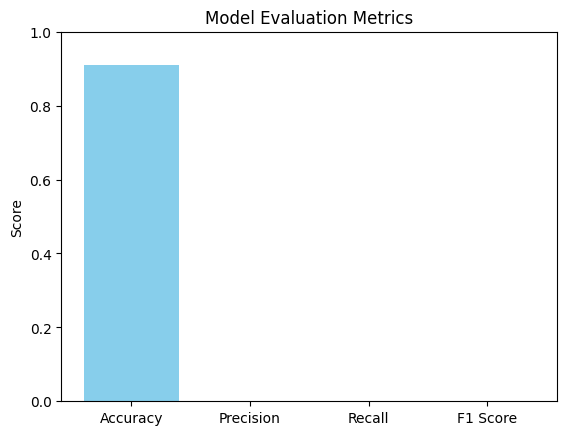

In [172]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}

plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Model Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()

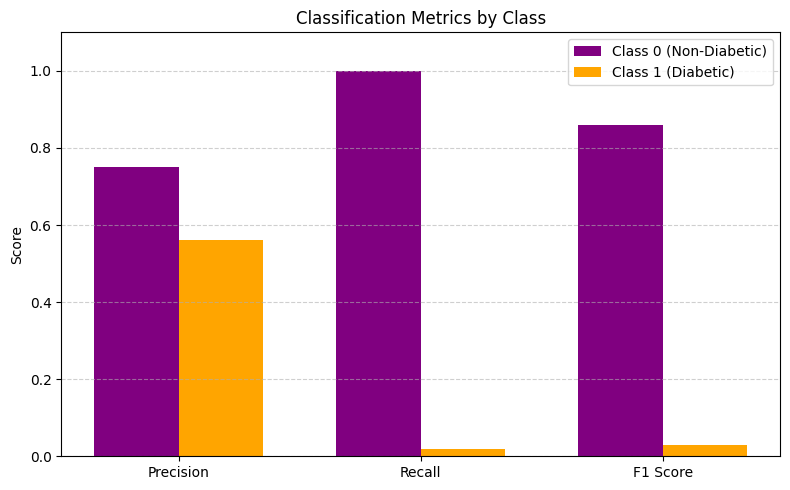

In [192]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from classification report
metrics = ["Precision", "Recall", "F1 Score"]

class_0 = [0.75, 1.00, 0.86]  # Non-diabetic
class_1 = [0.56, 0.02, 0.03]  # Diabetic

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, class_0, width, label='Class 0 (Non-Diabetic)', color='purple')
bars2 = ax.bar(x + width/2, class_1, width, label='Class 1 (Diabetic)', color='orange')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()
